## Deep Learning with ResNet-50. Image Classification, Binary. From Scratch, not Pre-Trained.   

### References as this is primarily copy and pasted after reading many blogs. 
This study primarily adapted from ResNet-50-for-Cats.Vs.Dogs. Most code blocks are copied verbetim.   

#### Cat and Dog - ResNet50   
https://github.com/mlhy/ResNet-50-for-Cats.Vs.Dogs/blob/master/CapstoneProjectReport.pdf
https://github.com/mlhy/ResNet-50-for-Cats.Vs.Dogs/blob/master/Preprocessing%20train%20dataset.ipynb  
https://github.com/mlhy/ResNet-50-for-Cats.Vs.Dogs/blob/master/ResNet-50%20for%20Cats.Vs.Dogs..ipynb  

#### ResNet 50 From Scratch, this is a good example, but can't adapt to binary without some adjustments  
Hand images making numbers with fingers, 6 classes 0,1,2,3,4,5  
Need to convert code to train and test binary  
Other than that appears to be of quality  
https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb  

#### Cat and Dog - Not ResNet  
Good detail EDA, loading, image crop/flip/zoom: https://thedatafrog.com/en/articles/dogs-vs-cats/
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/  

#### Building powerful image class model w/ little data (Augmentation / ImageDataGenerator)  
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  

#### To Do - General  
- research and read parts not familiar with, ex: no head and load of weights, understand significance 
- baseline with simple model (in-progress)  
- compare to pre-trained (done)  
- get on GPU once done  
- time benchmarking at key areas  
- ImageDataGenerator - image augmentation / data transformation with zoom, crop, rotate, etc...  


#### To Do - Specifics  
- preprocess, automate    
- performance charts    
- binary classification 

#### To Do - Immediate for functionality
tf.add solved issue, but is it working, getting new error, try two diff versions of this
conv_block function in 3 Convolution block: update with Conv2D use this as template   
> https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb  
Lookup documentation as well   
Question is why did the author mix the old and new, copy and paste or structural issue?

In [57]:
# CLEAN THIS UP
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, IMAGE
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, merge, Convolution2D, GlobalAveragePooling2D
from keras.utils import np_utils, layer_utils, plot_model
from keras.models import model_from_json, Model, load_model
from keras import backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
from keras.applications.imagenet_utils import preprocess_input

from resnets_utils import *
from IPython.display import SVG
import pydot
import scipy.misc

SyntaxError: trailing comma not allowed without surrounding parentheses (<ipython-input-57-fb33535ae236>, line 15)

## Deep Learning ResNet-50: Process
1 Download DataSet  
2 Preprocess 
- !!! automate
- Create directory structure  
- Train has sub directories cat and dog  
- Test  has sub directories cat and dog  
- Resize, rescale, clean, etc  
- Split and place in directories  

3 Build the Structure for the Classifier - ResNet-50  
- Define Identity Block  
- Define Convolutional Block  
- Build the structure of ResNet-50 without top layer  
- Load weights  
- Add top layer ti ResNet-50   
- Setup training attribute  
- Combine the model  

!!! Transfer Learning? - Review, our internal best model, or using a pre-trained?  What does?  

4 Train  
- save the best model 
- !!! Put in the training accuracy chart

5 Test  
6 Analyze Performance  
- Accuracy  
- Time  
- !!! Confusion matrix, put in and use more granular approach

### Download Data Set
Put in link to Kaggle and description


### Step 2 Preprocess Data: Recreate process and automate creation, copy, count, split
Train has sub directories cat and dog  
Test  has sub directories cat and dog  

### Step 2 Preprocess Data: Split and place in directories

### Step 2 Preprocess Data: Resize, rescale, clean, etc

In [49]:
# RESIZE
image_width = 224
image_height = 224
image_size = (image_width, image_height)

In [50]:
# RESCALE TRAINING DATA: 3 LAYERS OF 255 (RED GREEN BLUE) -> 1 LAYER GREYSCALE BTW 0 AND 1
# !!! IS THE DESCRIPTION ABOVE CORRECT?
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'C:/Users/DJ/Downloads/dogs-vs-cats/train/',
        target_size=image_size, 
        batch_size=16,
        class_mode='binary')

Found 3002 images belonging to 2 classes.


In [51]:
# RESCALE TEST DATA
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(
        'C:/Users/DJ/Downloads/dogs-vs-cats/test/', 
        target_size=image_size,  
        batch_size=16,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


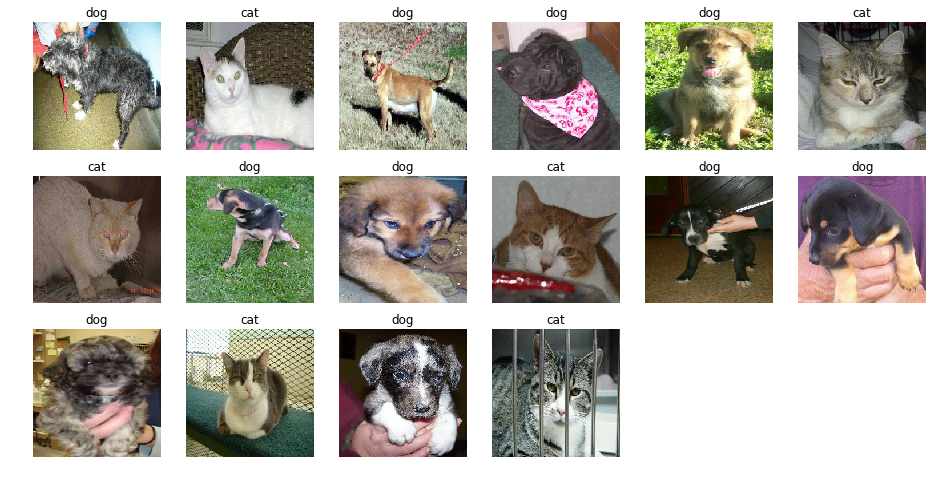

In [52]:
# VISUALIZE 16 RANDOM TRAINING IMAGES AT
# 16 IS BATCH SIZE, USED FOR EFFICIENT PROCESSING
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

### Step 3 Build the structure of ResNet-50 for Cats vs Dogs: Define Identity Block 

In [108]:
# CAT DOG, OLDER STYLE THROWING ISSUE
#def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

# SIX CLASS NEWER STYLE
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
#    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
#    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same',
               name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
#    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tf.add(X, X_shortcut)
   # X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X    

### 3 Build the structure of ResNet-50 for Cats vs Dogs: Define Convolutional Block  

In [109]:
# SIX FINGER PUTS ALL MODEL INTO FUNCTION, MORE ELEGANT IT SEEMS

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
#    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
#    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
#    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
#    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid',  name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    #X = Add()([X, X_shortcut])
    #X_add_shortcut = tf.add(x, X_shortcut)
    #!!! had problems with this is it working?
    X = tf.add(X, X_shortcut)
    #X = merge([X, X_shortcut], mode='sum')
    X = Activation('relu')(X)
      
    return X

### Step 3 Build the structure of ResNet-50 for Cats vs Dogs: Without top layer   

In [110]:
def ResNet50(input_shape=(image_width, image_height, 3), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
#    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((7,7), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
# x = Dropout(0.5)(x)
    X = Dense(classes, activation='sigmoid', name='output' + str(classes))(X)
#    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
      
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

### Step 3 Build the structure of ResNet-50 for Cats vs Dogs

In [111]:
model = ResNet50(input_shape = (image_width, image_height, 3), classes = 2)
#model = Model(input=base_model.input, output=x)

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

### Step 3 Build the structure of ResNet-50 for Cats vs Dogs: Compile the model

In [77]:
# six class example: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

NameError: name 'model' is not defined

### Step 4 Train the Model: Save Best Model

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [ ]:
# !!! CREATE A LOG DIRECTORY
model.fit_generator(
        train_generator,
        samples_per_epoch=2048,
        nb_epoch=40,
        validation_data=validation_generator,
        nb_val_samples=1024,
        callbacks=[best_model, TensorBoard(log_dir='./logs', histogram_freq=1)])

### Step 4 Train the Model: Save Best Model

In [ ]:
with open('resnet.json', 'w') as f:
    f.write(model.to_json())

### 5 Test the Model: Preprocess
!!! Do this in original step

In [ ]:
def get_image(index):
    img = cv2.imread('test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = 12500

In [ ]:
### What is this doing? why pre populate array with zero 

In [ ]:
from tqdm import *

image_matrix = np.zeros((test_num, image_width, image_height, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

### 6 Performance and Visualization

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB

### Draw feature heatmap
The shape of the output of the base model is (7, 7, 2048).

The shape of the weights of full connection is (2048, 1).

In order to draw the heatmap, I calculated the Class Activation Mapping (cam) of the output of the network then used OpenCV to visualize the result.

$cam = (P-0.5)*output*w$

cam: class activation mapping
P: the probability of cats or dogs
output: the output of base model
w: the weights of the full connection

In [ ]:
weights = model.layers[-1].get_weights()[0]
model2 = Model(input=model.input, output=[base_model.output, model.output])

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(20):
    img = cv2.imread('test/%d.jpg' % random.randint(1, test_num))
    img = cv2.resize(img, image_size)
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    [base_model_outputs, prediction] = model2.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    base_model_outputs = base_model_outputs[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    cam = (prediction - 0.5) * np.matmul(base_model_outputs, weights)

    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    
    plt.axis('off')
    plt.imshow(out[:,:,::-1])